# Why do we need validation?

##### Keywords: empirical risk minimization, Hoeffding's inequality, hypothesis space, training error, out-of-sample error, testing set, training set, test error, validation error, complexity parameter, cross-validation

## Contents
{:.no_toc}
*  
{: toc}

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def make_simple_plot():
    fig, axes=plt.subplots(figsize=(12,5), nrows=1, ncols=2);
    axes[0].set_ylabel("$y$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([-2,2])
    axes[1].set_ylim([-2,2])
    plt.tight_layout();
    return axes
def make_plot():
    fig, axes=plt.subplots(figsize=(20,8), nrows=1, ncols=2);
    axes[0].set_ylabel("$p_R$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([0,1])
    axes[1].set_ylim([0,1])
    axes[0].set_xlim([0,1])
    axes[1].set_xlim([0,1])
    plt.tight_layout();
    return axes

## Revisiting the model

Let $x$ be the fraction of religious people in a county and $y$ be the probability of voting for Romney as a function of $x$. In other words $y_i$ is data that pollsters have taken which tells us their estimate of people voting for Romney and $x_i$ is the fraction of religious people in county $i$. Because poll samples are finite, there is a margin of error on each data point or county $i$, but we will ignore that for now.

In [3]:
dffull=pd.read_csv("data/religion.csv")
dffull.head()

,promney,rfrac
0,0.047790,0.00
1,0.051199,0.01
2,0.054799,0.02
3,0.058596,0.03
4,0.062597,0.04


In [4]:
x=dffull.rfrac.values
f=dffull.promney.values

In [5]:
df = pd.read_csv("data/noisysample.csv")
df.head()

,f,i,x,y
0,0.075881,7,0.07,0.138973
1,0.085865,9,0.09,0.050510
2,0.096800,11,0.11,0.183821
3,0.184060,23,0.23,0.057621
4,0.285470,33,0.33,0.358174


In [6]:
from sklearn.cross_validation import train_test_split
datasize=df.shape[0]
#split dataset using the index, as we have x,f, and y that we want to split.
itrain,itest = train_test_split(range(30),train_size=24, test_size=6)
xtrain= df.x[itrain].values
ftrain = df.f[itrain].values
ytrain = df.y[itrain].values
xtest= df.x[itest].values
ftest = df.f[itest].values
ytest = df.y[itest].values

## Validation

A separate validation set is needed because what we have done in picking a given polynomial degree $d$ as the best hypothesis is that we have used the test set as a training set. How?

Our process used the training set to fit for the **parameters**(values of the coefficients) of the polynomial of given degree $d$ based on minimizing the traing set error (empirical risk minimization). We then calculated the error on the test set at that $d$. If we go further and choose the best $d$ based on minimizing the test set error, we have then "fit for" $d$ on the test set. We will thus call $d$ a **hyperparameter** of the model.

In this case, the test-set error will underestimate the true out-of-sample error. Furthermore, we have **contaminated the test set** by fitting for $d$ on it; it is no longer a true test set.

Thus, we must introduce a new **validation set** on which the complexity parameter $d$ is fit, and leave out a test set which we can use to estimate the true out-of-sample performance of our learner. The place of this set in the scheme of things is shown below:

![m:caption](images/train-validate-test.png)

We have split the old training set into a training set and a validation set, holding the old test aside for FINAL testing AFTER we have "fit" for complexity $d$. Obviously we have decreased the size of the data available for training further, but this is a price we must pay for obtaining a good estimate of the out-of-sample risk $\cal{E_{out}}$ (also denoted as risk $R_{out}$) through the test risk $\cal{E_{test}}$ ($R_{test}$).

![m:caption](images/train-validate-test-cont.png)

The validation process is illustrated in these two figures. We first loop over all the hypothesis sets that we wish to consider: in our case this is a loop over the complexity parameter $d$, the degree of the polynomials we will try and fit. Then for each degree $d$, we obtain a best fit model $g^-_d$ where the "minus" superscript indicates that we fit our model on the new training set which is obtained by removing ("minusing") a validation chunk (often the same size as the test chunk) from the old training set. We then "test" this model on the validation chunk, obtaining the validation error for the best-fit polynomial coefficients and for degree $d$. We move on to the next degree $d$ and repeat the process, just like before. We compare all the validation set errors, just like we did with the test errors earlier, and pick the degree $d_*$ which minimizes this validation set error.

![caption](images/train-validate-test3.png)

Having picked the hyperparameter $d_\*$, we retrain using the hypothesis set $\cal{H_\*}$ on the entire old training-set to find the parameters of the polynomial of order $d_\*$ and the corresponding best fit hypothesis $g_\*$. Note that we left the minus off the $g$ to indicate that it was trained on the entire old traing set. We now compute the test error on the test set as an estimate of the test risk $\cal{E_{test}}$.

Thus the **validation** set is the set on which the hyperparameter is fit. This method of splitting the data $\cal{D}$ is called the **train-validate-test** split.

### Properties of the validation set

First assume that the validation set is acting like a test set. then, for the same reasons as in the case of a test set, the validation risk or error is an unbiased estimate of the out of sample risk. Secondly, the Hoeffding bound for a validation set is then for the same reason identical to that of the test set.

More often though the validation set is used in a model selection process. Here we wish to choose the complexity parameter $d$, something we **wrongly** already attempted to do on our previous test set.

Notice that the process of validation consists of fixing $d$ and finding the best fit $g^\*$ on the training set. We then calculate as many risks as our parameter grid on the validation set with the different fit hypothesis, and choose the $d, g^\*$ combination with the lowest validation set risk. Now, $R_{val}(g^{-\*}, d^\*)$ also has an optimistic bias, and its Hoeffding bound must now take into account the grid-size as the effecting size of the hypothesis space. This size from hyperparameters is typically a smaller size than that from parameters.

We finally now retrain on the entire train+validation set using the appropriate  $(g^{-\*}, d^\*)$ combination. This works as training a given model with more data typically reduces the risk even further. (One can show this using learning curves but thats out of our scope).

### Working it out

We carry out this process for one training/validation split below. Note the smaller size of the new training set. We hold the test set at the same size.

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [8]:
def make_features(train_set, test_set, degrees):
    traintestlist=[]
    for d in degrees:
        traintestdict={}
        traintestdict['train'] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        traintestdict['test'] = PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
        traintestlist.append(traintestdict)
    return traintestlist

In [9]:
#we split the training set down further
intrain,invalid = train_test_split(itrain,train_size=18, test_size=6)
xntrain= df.x[intrain].values
fntrain = df.f[intrain].values
yntrain = df.y[intrain].values
xnvalid= df.x[invalid].values
fnvalid = df.f[invalid].values
ynvalid = df.y[invalid].values

degrees=range(21)
error_train=np.empty(len(degrees))
error_valid=np.empty(len(degrees))
trainvalidlists=make_features(xntrain, xnvalid, degrees)

#we now train on the smaller training set
for d in degrees:#for increasing polynomial degrees 0,1,2...
    #Create polynomials from x
    Xntrain = trainvalidlists[d]['train']
    Xnvalid = trainvalidlists[d]['test']
    #fit a model linear in polynomial coefficients on the new smaller training set
    est = LinearRegression()
    est.fit(Xntrain, yntrain)
    #predict on new training and validation sets and calculate mean squared error
    error_train[d] = mean_squared_error(yntrain, est.predict(Xntrain))
    error_valid[d] = mean_squared_error(ynvalid, est.predict(Xnvalid))

#calculate the degree at which validation error is minimized
mindeg = np.argmin(error_valid)
#need to remake polynomial features on the whole training set
ttlist=make_features(xtrain, xtest, degrees)
features_at_mindeg = ttlist[mindeg]['train']
test_features_at_mindeg = ttlist[mindeg]['test']
#fit on whole training set now. Put MSE in variable err.
#your code here
clf = LinearRegression()
clf.fit(features_at_mindeg, ytrain) # fit
#predict on the test set now and calculate error
pred = clf.predict(test_features_at_mindeg)
err = mean_squared_error(ytest, pred)

2


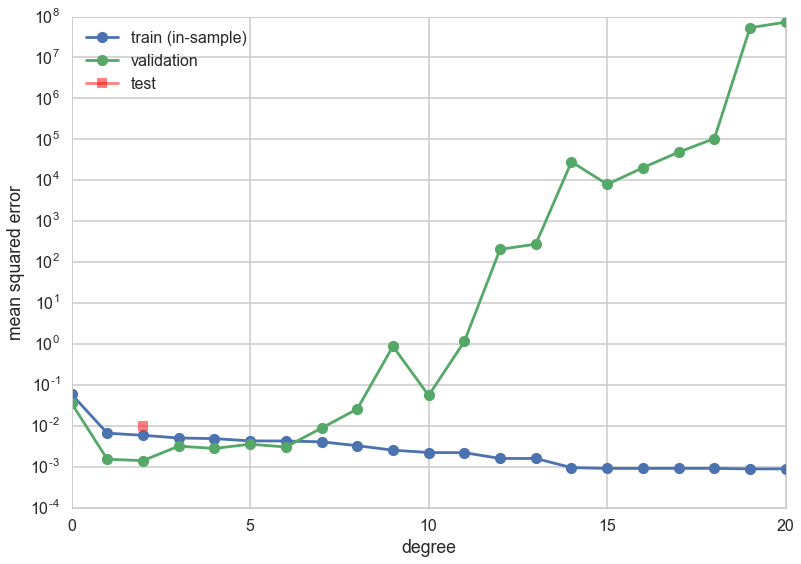

In [10]:
plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_valid, marker='o', label='validation')
plt.plot([mindeg], [err], marker='s', markersize=10, label='test', alpha=0.5, color='r')
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.yscale("log")
print(mindeg)

Lets do this again, choosing a new random split between training and validation data: 

In [11]:
intrain,invalid = train_test_split(itrain,train_size=18, test_size=6)
xntrain= df.x[intrain].values
fntrain = df.f[intrain].values
yntrain = df.y[intrain].values
xnvalid= df.x[invalid].values
fnvalid = df.f[invalid].values
ynvalid = df.y[invalid].values

degrees=range(21)
error_train=np.empty(len(degrees))
error_valid=np.empty(len(degrees))
trainvalidlists=make_features(xntrain, xnvalid, degrees)

for d in degrees:#for increasing polynomial degrees 0,1,2...
    #Create polynomials from x
    Xntrain = trainvalidlists[d]['train']
    Xnvalid = trainvalidlists[d]['test']
    #fit a model linear in polynomial coefficients on the training set
    est = LinearRegression()
    est.fit(Xntrain, yntrain)
    #calculate mean squared error
    error_train[d] = mean_squared_error(yntrain, est.predict(Xntrain))
    error_valid[d] = mean_squared_error(ynvalid, est.predict(Xnvalid))

mindeg = np.argmin(error_valid)
ttlist=make_features(xtrain, xtest, degrees)
features_at_mindeg = ttlist[mindeg]['train']
test_features_at_mindeg = ttlist[mindeg]['test']
clf = LinearRegression()
clf.fit(features_at_mindeg, ytrain) # fit
pred = clf.predict(test_features_at_mindeg)
err = mean_squared_error(ytest, pred)

2


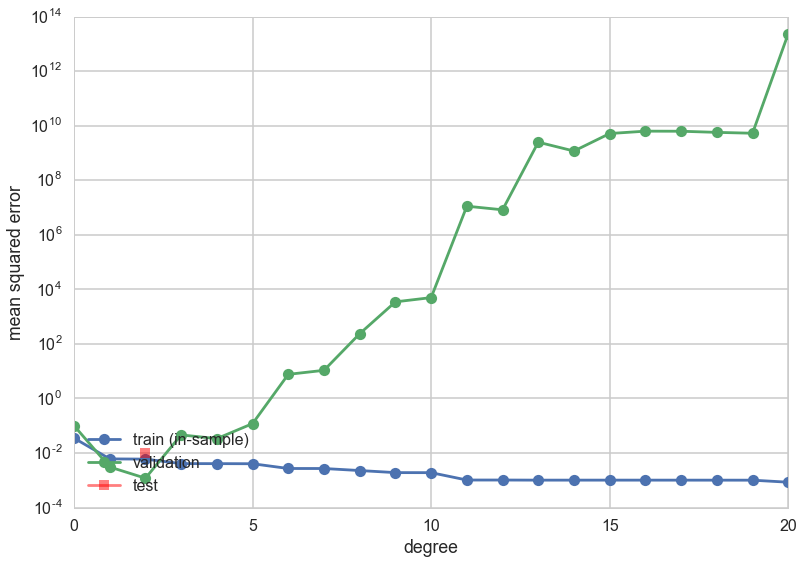

In [12]:
plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_valid, marker='o', label='validation')
plt.plot([mindeg], [err], marker='s', markersize=10, label='test', alpha=0.5, color='r')

plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='lower left')
plt.yscale("log")
print(mindeg)

This time the validation error minimizing polynomial degree might change! What happened?

## Cross Validation

### The problem

1. Since we are dealing with small data sizes here, you should worry that a given split exposes us to the peculiarity of the data set that got randomly chosen for us. This naturally leads us to want to choose multiple such random splits and somehow average over this process to find the "best" validation minimizing polynomial degree or complexity $d$.
2. The multiple splits process also allows us to get an estimate of how consistent our prediction error is: in other words, just like in the hair example, it gives us a distribution. So far we have been channeling the hair through the bootstrap, but choosing multiple splits  is another way to get different training samples..
3. Furthermore the validation set that we left out has two competing demands on it. The larger the set is, the better is our estimate of the out-of-sample error. So we'd like to hold out as much as possible. But the smaller the validation set is, the more data we have to train ourmodel on. Thus we can fit a better, more expressive model. We want to balance these two desires, and additionally, not be exposed to any peculiarities that might randomly arise in any single train-validate split of the old training set.

### The Idea

To deal with this we engage in a process called **cross-validation**, which is illustrated in the figure below, for a given hypothesis set $\cal{H}_a$ with complexity parameter $d=a$ (the polynomial degree). We do the train/validate split, not once but multiple times. 

In the figure below we create 4-folds from the training set part of our data set $\cal{D}$. By this we mean that we divide our set roughly into 4 equal parts. As illustrated below, this can be done in 4 different ways, or folds. In each fold we train a model on 3 of the parts. The model so trained is denoted as $g^-_{Fi}$, for example $g^-_{F3}$ . The minus sign in the superscript once again indicates that we are training on a reduced set. The $F3$ indicates that this model was trained on the third fold. Note that the model trained on each fold will be different!

For each fold, after training the model, we calculate the risk or error on the remaining one validation part. We then add the validation errors together from the different folds, and divide by the number of folds to calculate an average error. Note again that this average error is an average over different models $g^-_{Fi}$. We use this error as the validation error for $d=a$ in the validation process described earlier.

![m:caption](images/train-cv2.png)

Note that the number of folds is equal to the number of splits in the data. For example, if we have 5 splits, there will be 5 folds. To illustrate cross-validation consider below fits in $\cal{H}_0$ and $\cal{H}_1$ (means and straight lines) to a sine curve, with only 3 data points.

We have described cross-validation here from the perspective of sensibly fitting for the complexity hyperparameter $d$. But we can use it just like a pure validation set as well, just making sure we arent getting strange results due to a wierdly sampled validation set. In that case, (it can also shown that) **cross-validation error is an unbiased estimate of the out of sample-error**.

Notice  that just like the bootstraps we do in frequentist inference, **cross-validation is a re-sampling method**. Indeed, a question might be, why not use bootstrap instead. See http://stats.stackexchange.com/questions/18348/differences-between-cross-validation-and-bootstrapping-to-estimate-the-predictio , and note that the so-called "out-of-bag" errors from "bagging" in random forests utilizes the bootstrap.

### The entire description of K-fold Cross-validation

We put thogether this scheme to calculate the error for a given polynomial degree $d$ with the method we used earlier to choose a model given the validation-set risk as a function of $d$:

1. create `n_folds` partitions of the training data. 
2. We then train on `n_folds -1` of these partitions, and test on the remaining partition. There are `n_folds` such combinations of partitions (or folds), and thus we obtain `n_fold` risks.
3. We average the error or risk of all such combinations to obtain, for each value of $d$, $R_{dCV}$.
4. We move on to the next value of $d$, and repeat 3
5. and then find the optimal value of d that minimizes risk $d=*$.
5. We finally use that value to make the final fit in $\cal{H}_*$ on the entire old training set.

![caption](images/train-cv3.png)

Let us now do 4-fold cross-validation on our Romney votes data set. We increase the complexity from degree 0 to degree 20. In each case we take the old training set, split in 4 ways into 4 folds, train on 3 folds, and calculate the validation error on the ramining one. We then average the erros over the four folds to get a cross-validation error for that $d$. Then we did what we did before: find the hypothesis space $\cal{H_*}$ with the lowest cross-validation error, and refit it using the entire training set. We can then use the test set to estimate $E_{out}$.

In [13]:
from sklearn.cross_validation import KFold
n_folds=4
degrees=range(21)
results=[]
for d in degrees:
    hypothesisresults=[]
    for train, test in KFold(24, n_folds): # split data into train/test groups, 4 times
        tvlist=make_features(xtrain[train], xtrain[test], degrees)
        clf = LinearRegression()
        clf.fit(tvlist[d]['train'], ytrain[train]) # fit
        hypothesisresults.append(mean_squared_error(ytrain[test], clf.predict(tvlist[d]['test']))) # evaluate score function on held-out data
    results.append((np.mean(hypothesisresults), np.min(hypothesisresults), np.max(hypothesisresults), np.std(hypothesisresults))) # average

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


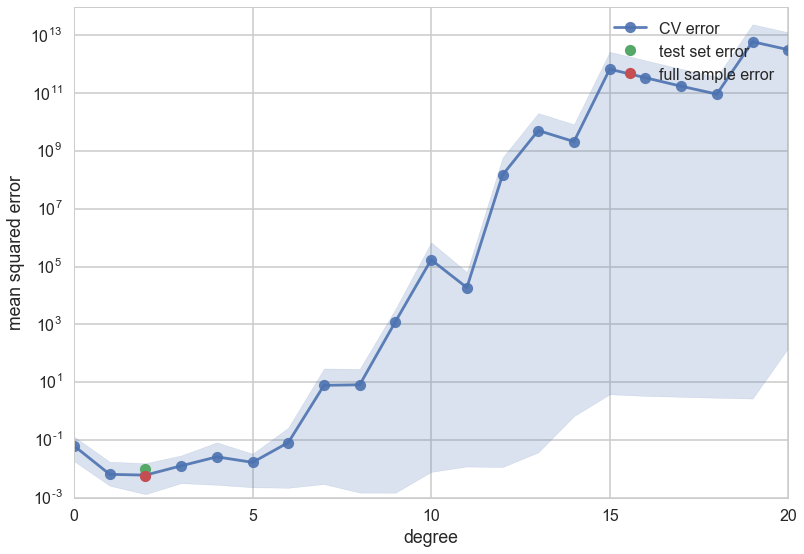

In [14]:
mindeg = np.argmin([r[0] for r in results])
ttlist=make_features(xtrain, xtest, degrees)
#fit on whole training set now.
clf = LinearRegression()
clf.fit(ttlist[mindeg]['train'], ytrain) # fit
pred = clf.predict(ttlist[mindeg]['test'])
err = mean_squared_error(pred, ytest)
errtr=mean_squared_error(ytrain, clf.predict(ttlist[mindeg]['train']))
errout=0.8*errtr+0.2*err
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
#plt.errorbar(degrees, [r[0] for r in results], yerr=[r[1] for r in results], marker='o', label='CV error', alpha=0.5)
plt.plot(degrees, [r[0] for r in results], marker='o', label='CV error', alpha=0.9)
plt.fill_between(degrees, [r[1] for r in results], [r[2] for r in results], color=c0, alpha=0.2)


plt.plot([mindeg], [err], 'o',  label='test set error')
plt.plot([mindeg], [errout], 'o',  label='full sample error')


plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper right')
plt.yscale("log")

We see that the cross-validation error minimizes at a low degree, and then increases. Because we have so few data points the spread in fold errors increases as well.

So now we have an average out of sample error, matched to the in-sample error, and error bars telling is that  the entire order 1-8 polynomial region (roughly) is trustable...

### What does Cross Validation do?

One can think about the validation process as one that estimates $R_{out}$ directly, on the validation set. It's critical use is in the model selection process. Once you do that you can estimate $R_{out}$ using the test set as usual, but now you have also got the benefit of a robust average and error bars.

One key subtlety to remember about cross-validation is that in the risk averaging process, you are actually averaging over different $g^-$ models, with different parameters. You arrive at the least risk for the hyperparameter and then refit on the entire training set, which will likely give you slightly different parameters as well.